# ETF穿越120日均线

* **买入：**收盘价上穿120日均线
* **卖出：**收盘价下穿120日均线

---

非常简单的策略。但是效果看上去还不错，无论在`510300`还是`510310`两支产品上均超过了基准收益。

|        |   基准收益 |   策略收益 |   基准年化收益 |   策略年化收益 |   基准最大回撤 |   策略最大回撤 |
|-------:|-----------:|-----------:|---------------:|---------------:|---------------:|---------------:|
| 510300 |   0.583337 |    1.66526 |      0.0787442 |       0.224793 |      -0.461035 |     -0.06      |
| 510310 |   0.794892 |    1.66511 |      0.120365  |       0.252137 |      -0.456236 |     -0.0833382 |

|        |   剩余现金 |   交易次数 |   未结束交易次数 |   未结束交易购买金额 |   盈利次数 |   亏损次数 | 盈利次数占比   |   盈利(含交易费)次数 |   亏损(含交易费)次数 | 盈利(含交易费)次数占比   |   盈利交易平均获利 |   亏损交易平均亏损 |   盈利(含交易费)交易平均获利 |   亏损(含交易费)交易平均亏损 |   盈亏总额 |   手续费总额 |   手续费均值 | 最大盈利%   | 最大亏损%   | 最大(含交易费)盈利%   | 最大(含交易费)亏损%   |
|-------:|-----------:|-----------:|-----------------:|---------------------:|-----------:|-----------:|:---------------|---------------------:|---------------------:|:-------------------------|-------------------:|-------------------:|-----------------------------:|-----------------------------:|-----------:|-------------:|-------------:|:------------|:------------|:----------------------|:----------------------|
| 510300 |     175.55 |         29 |                1 |              28252.8 |         15 |         13 | 51.72%         |                   15 |                   13 | 51.72%                   |            1387.73 |            -159.12 |                      1387.73 |                      -159.12 |    18747.5 |       319.15 |          5.6 | 88.44%      | -5.96%      | 88.35%                | -6.02%                |
| 510310 |     118.09 |         19 |                1 |              26442   |         12 |          5 | 63.16%         |                   12 |                    6 | 63.16%                   |            1570.15 |            -415.62 |                      1570.15 |                      -346.35 |    16763.7 |       203.61 |          5.5 | 91.57%      | -5.51%      | 91.48%                | -5.56%                |

In [1]:
import gquant
import abupy
import QUANTAXIS as QA
import gquant.jupyter_helper
gquant.jupyter_helper.init()
import talib
import matplotlib.pyplot as plt
import pandas as pd
from abupy.ExtBu.empyrical import stats

you are using non-interactive mdoel quantaxis


# 原始数据

In [22]:
START='1990-01-01'
END='2019-12-31'
DEFAULT_MA=120
CODE='510310'

def get_data(code, start, end,ma=DEFAULT_MA):
    data=QA.QA_fetch_index_day_adv(code,start=start,end=end).data.reset_index(level=1, drop=True)
    data['MA']=QA.MA(data['close'],ma)
    data['prev_MA']=data['MA'].shift()
    data['prev_close']=data['close'].shift()
    data['date'] = data.index.get_level_values(0)
    data['date'] = pd.to_datetime(data['date'])
    # 星期一为0，星期天为6
    data['weekday'] = data['date'].dt.weekday
    data['nextday']=data['weekday'].shift(-1)
    data['prevday']=data['weekday'].shift()
    return data

In [13]:
# 易方达沪深300发起式ETF
data_000300=get_data('000300',start=START,end=END)
# 易方达沪深300发起式ETF
data_510310=get_data('510310',start=START,end=END)
# 华泰柏瑞沪深300ETF
data_510300=get_data('510300',start=START,end=END)

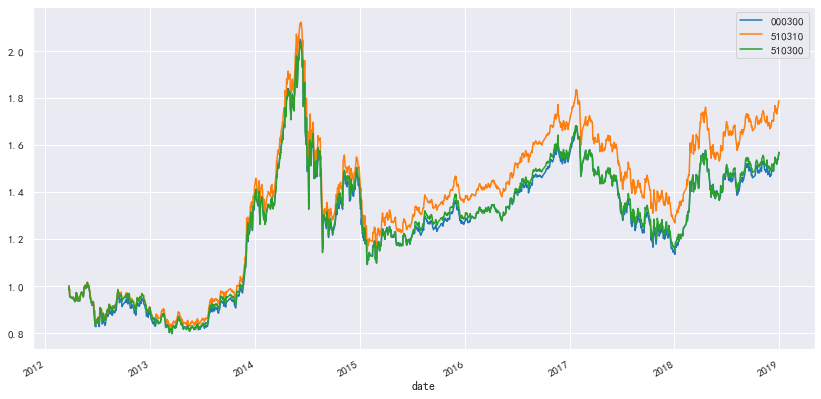

In [14]:
data_close=pd.DataFrame({'000300':data_000300.close,'510310':data_510310.close,'510300':data_510300.close}).dropna()
(data_close/data_close.iloc[0]).plot()
plt.legend()

In [15]:
data_close.pct_change().describe()

,000300,510310,510300
count,1650.0000,1650.0000,1650.0000
mean,0.0004,0.0005,0.0004
std,0.0148,0.0156,0.0158
min,-0.0875,-0.0997,-0.1001
25%,-0.0056,-0.0053,-0.0060
50%,0.0004,0.0000,0.0003
75%,0.0070,0.0066,0.0068
max,0.0671,0.1002,0.0999


In [16]:
data_close.iloc[-1]/data_close.iloc[0]

000300    1.5677
510310    1.7890
510300    1.5687
dtype: float64

<AxesSubplot:xlabel='date'>

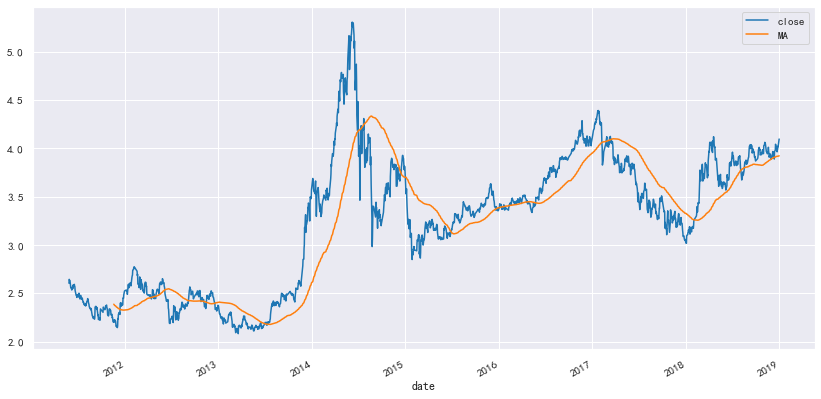

In [18]:
data_510300[['close','MA']].plot()

In [29]:
from gquant.backtest import backtest

def simple_trade_func(data,**kwargs):
    data.loc[(data['close']>data['MA'])&(data['prev_close']<data['prev_MA']),'buy']=1
    data.loc[(data['close']<data['MA'])&(data['prev_close']>data['prev_MA']),'sell']=1
    return data

def simple_buy_price_func(index, row, data):
    return row['open']

def simple_sell_price_func(index, row, data):
    return row['close']

## 510300

In [38]:
x = get_data('510300', START, END)
x=simple_trade_func(x)
m1 = backtest(x, benchmark_pd=x, buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
             buy_price_func=simple_buy_price_func, sell_price_func=simple_sell_price_func)
m1.stats()
# m.report().to_frame().T
# m.plot_cash()

1852it [00:00, 4205.19it/s]


基准收益      0.5833
策略收益      1.6653
基准年化收益    0.0787
策略年化收益    0.2248
基准最大回撤   -0.4610
策略最大回撤   -0.0600
dtype: float64

In [39]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(m1.report())

剩余现金                175.55
交易次数                    29
未结束交易次数                  1
未结束交易购买金额         28252.80
盈利次数                    15
亏损次数                    13
盈利次数占比              51.72%
盈利(含交易费)次数              15
亏损(含交易费)次数              13
盈利(含交易费)次数占比        51.72%
盈利交易平均获利           1387.73
亏损交易平均亏损           -159.12
盈利(含交易费)交易平均获利     1387.73
亏损(含交易费)交易平均亏损     -159.12
盈亏总额              18747.50
手续费总额               319.15
手续费均值                 5.60
最大盈利%               88.44%
最大亏损%               -5.96%
最大(含交易费)盈利%         88.35%
最大(含交易费)亏损%         -6.02%
dtype: object


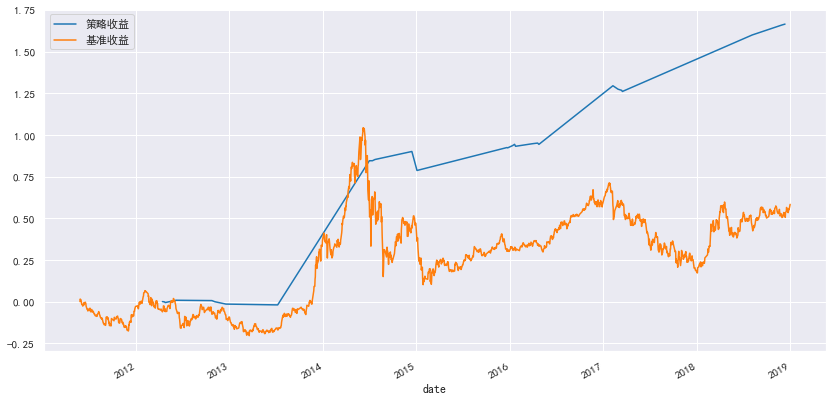

In [40]:
m1.plot_cash()

## 510310

In [41]:
x = get_data('510310', START, END)
x=simple_trade_func(x)
m2 = backtest(x, benchmark_pd=x, buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
             buy_price_func=simple_buy_price_func, sell_price_func=simple_sell_price_func)
m2.stats()
# m.report().to_frame().T
# m.plot_cash()

1651it [00:00, 4689.39it/s]


基准收益      0.7949
策略收益      1.6651
基准年化收益    0.1204
策略年化收益    0.2521
基准最大回撤   -0.4562
策略最大回撤   -0.0833
dtype: float64

In [42]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(m2.report())

剩余现金                118.09
交易次数                    19
未结束交易次数                  1
未结束交易购买金额         26442.00
盈利次数                    12
亏损次数                     5
盈利次数占比              63.16%
盈利(含交易费)次数              12
亏损(含交易费)次数               6
盈利(含交易费)次数占比        63.16%
盈利交易平均获利           1570.15
亏损交易平均亏损           -415.62
盈利(含交易费)交易平均获利     1570.15
亏损(含交易费)交易平均亏损     -346.35
盈亏总额              16763.70
手续费总额               203.61
手续费均值                 5.50
最大盈利%               91.57%
最大亏损%               -5.51%
最大(含交易费)盈利%         91.48%
最大(含交易费)亏损%         -5.56%
dtype: object


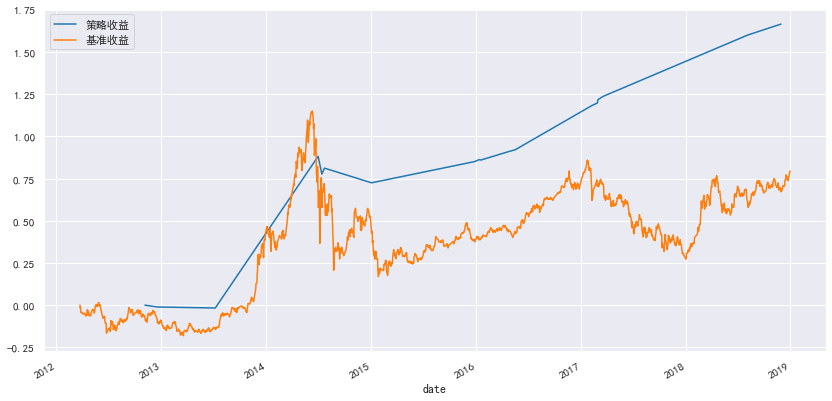

In [43]:
m2.plot_cash()

In [54]:
print(pd.DataFrame({'510300':m1.stats(),'510310':m2.stats()}).T.to_markdown())

|        |   基准收益 |   策略收益 |   基准年化收益 |   策略年化收益 |   基准最大回撤 |   策略最大回撤 |
|-------:|-----------:|-----------:|---------------:|---------------:|---------------:|---------------:|
| 510300 |   0.583337 |    1.66526 |      0.0787442 |       0.224793 |      -0.461035 |     -0.06      |
| 510310 |   0.794892 |    1.66511 |      0.120365  |       0.252137 |      -0.456236 |     -0.0833382 |


In [55]:
print(pd.DataFrame({'510300':m1.report(),'510310':m2.report()}).T.to_markdown())

|        |   剩余现金 |   交易次数 |   未结束交易次数 |   未结束交易购买金额 |   盈利次数 |   亏损次数 | 盈利次数占比   |   盈利(含交易费)次数 |   亏损(含交易费)次数 | 盈利(含交易费)次数占比   |   盈利交易平均获利 |   亏损交易平均亏损 |   盈利(含交易费)交易平均获利 |   亏损(含交易费)交易平均亏损 |   盈亏总额 |   手续费总额 |   手续费均值 | 最大盈利%   | 最大亏损%   | 最大(含交易费)盈利%   | 最大(含交易费)亏损%   |
|-------:|-----------:|-----------:|-----------------:|---------------------:|-----------:|-----------:|:---------------|---------------------:|---------------------:|:-------------------------|-------------------:|-------------------:|-----------------------------:|-----------------------------:|-----------:|-------------:|-------------:|:------------|:------------|:----------------------|:----------------------|
| 510300 |     175.55 |         29 |                1 |              28252.8 |         15 |         13 | 51.72%         |                   15 |                   13 | 51.72%                   |            1387.73 |            -159.12 |                      1387.73 |                      -159.12 |    1874